#  Engineer Javier Andrés Tiniaco Leyba

#  Feature selection using BDS and MIFS

- BDS: Bidirectional search
- MIFS: Mutual information feature selection

I wil be using the white-wine dataset which can be downloaded from [here](https://archive.ics.uci.edu/ml/datasets/Wine+Quality)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import label_binarize

from sklearn.metrics import mutual_info_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [2]:
wine = pd.read_csv("../winequality-white.csv",sep=";")

In [3]:
wine.shape

(4898, 12)

In [4]:
wine_arr = np.array(wine)

### Wrapper evaluation function

Function evaluation for the wrapper approximation of the subset search. A RandomForestClassifier is being used, trained with 5-fold cross-validation leaving 30% of data for a final test. A random state of value "0" is used for reproducibility.

Evaluate subset via 5-fold cross validation score, without one hot coding classes.

In [5]:
# Data must be a numpy array and the last column must be the class
def eval_subset(S,data,rand_state=0):
    rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
    cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=rand_state)
    return cross_val_score(rf, data[:,list(S)], data[:,-1], cv=cv).mean()

A baseline score is constructed by making use of all the predictors, so that other results can be compared against it.

In [6]:
print("Model score using all predictors: ", 100*eval_subset([0,1,2,3,4,5,6,7,8,9,10],wine_arr), "%")

Model score using all predictors:  67.26530612244898 %


### Bidirectional search implementation

M is the number of features to keep which must be a positive integer greater than zero and at maximun equal to the number of features.

In [7]:
def BDS(m,data):
    # m = number of features to keep
    data = np.array(data)
    samples, features = data.shape
    features -= 1 # Exclude class
    
    if m < 1 or type(m) != type(1) or m > features:
        print("Invalid number of features.")
        return
    
    SBS = list(range(features)) 
    SFS = []
    
    while len(SFS) != m or len(SBS) != m:

        if len(SFS) != m:
            best_feat, best_score = -1, 0
            for feat in list(SBS):
                if feat in SFS:continue
                SFS.append(feat)
                score_val = eval_subset(SFS,data)
                if score_val > best_score: 
                    best_feat, best_score = feat, score_val
                SFS.pop()
            if best_feat != -1:SFS.append(best_feat)
            
        if len(SBS) != m:
            best_feat, best_score = -1, 0
            for feat in list(SBS):
                if feat in SFS:continue
                SBS.remove(feat)
                score_val = eval_subset(SBS,data)
                if score_val > best_score: 
                    best_feat, best_score = feat, score_val
                SBS.append(feat)
            if best_feat != -1:SBS.remove(best_feat)
            
    return (best_score,SFS)

In [9]:
bds_best_score, bds_best_subset = BDS(5,wine_arr)
bds_best_score, bds_best_subset

(0.6502040816326531, [10, 3, 6, 1, 4])

It is possible to see from the executions above, that we can get different subsets for the same number of attributes to keep, since the evaluation function has some random component in it (cross validation), however, the accuracy for those subsets is quite similar. <br>
Note: For a intel i3-4160 CPU the execution of BDS(5,wine_arr) took 2 minutes 30 seconds.

### MIFS - Mutual information based feature selection

In [10]:
def MIFS(m,beta,data,isprint=0):
    """ MIFS algorithm Battiti 1994:
        m = number of features to keep.
        isprint = 1 prints sequence of choices
        data = array of dim = samples,features+1
    """
    data = np.array(data)
    samples, features = data.shape
    features -= 1 # Exclude class
    labels = data[:,-1]
    
    if m < 1 or type(m) != type(1) or m > features:
        print("Invalid number of features.")
        return
    
    F = list(range(features)) 
    S = []
    
    XS = np.argmax([mutual_info_score(labels, data[:,attr]) for attr in F])
    if isprint: print("First feature elected:" ,print(XS))
    
    F.remove(XS)
    S.append(XS)
    #print(F,S)
    
    while len(S) != m:
        
        MIS = {xf:sum( mutual_info_score(data[:,xf],data[:,xs]) for xs in S) for xf in F}
        if isprint: print(MIS)
        XS = np.argmax( [mutual_info_score(labels,data[:,xf]) - beta*MIS[xf] for xf in F] )
        if isprint: print(XS)
        S.append(F[XS])
        F.remove(F[XS])
        if isprint: print(F,S)
        
    return S

In [11]:
MIFS(5,0.5,wine_arr,isprint=0)

[7, 0, 1, 9, 2]

Best subset given different values of beta.

In [12]:
mifs_solutions = [[round(beta,2),MIFS(5,beta,wine_arr)] for beta in np.arange(0,1.01,0.05)]

In [13]:
mifs_solutions

[[0.0, [7, 3, 10, 6, 4]],
 [0.05, [7, 10, 3, 4, 1]],
 [0.1, [7, 10, 1, 0, 2]],
 [0.15, [7, 10, 1, 0, 2]],
 [0.2, [7, 10, 0, 1, 2]],
 [0.25, [7, 10, 0, 1, 2]],
 [0.3, [7, 10, 0, 1, 2]],
 [0.35, [7, 0, 10, 1, 2]],
 [0.4, [7, 0, 1, 10, 9]],
 [0.45, [7, 0, 1, 10, 9]],
 [0.5, [7, 0, 1, 9, 2]],
 [0.55, [7, 0, 1, 9, 2]],
 [0.6, [7, 0, 1, 9, 2]],
 [0.65, [7, 0, 1, 9, 2]],
 [0.7, [7, 0, 1, 9, 2]],
 [0.75, [7, 0, 1, 9, 2]],
 [0.8, [7, 0, 1, 9, 2]],
 [0.85, [7, 0, 1, 9, 2]],
 [0.9, [7, 0, 1, 9, 2]],
 [0.95, [7, 0, 1, 9, 2]],
 [1.0, [7, 0, 1, 9, 2]]]

I have decided to keep the subset [7,0,1,9,2] because is the one that most repeats.

In [14]:
mifs_best_subset = [7, 0, 1, 9, 2]

###  PCA - Principal Component Analysis

In [15]:
pca = PCA()
pca.fit(wine_arr[:,:-1])

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [16]:
pca.explained_variance_ratio_

array([9.09657344e-01, 7.93338631e-02, 1.01542742e-02, 5.06004450e-04,
       3.23409395e-04, 8.72769740e-06, 6.72986618e-06, 5.39060918e-06,
       4.07002123e-06, 1.86525322e-07, 1.49217279e-10])

As we can see, with the first to components more than 95% of the variance is covered, so we till keep only those and transform the original feature space to the new dimensional space.

In [17]:
principal_2 = pca.components_[[0,1],:]

In [18]:
principal_2.shape

(2, 11)

###  Model evaluation with the feature subsets obtained via different feature selecion methods

For each of the best feature subsets selected via different methods, the accuracy, precision, recall, ROC curve and AUC value will be obtained, so that a final comparison can be made. 

In [19]:
classes = list(set(wine.quality))
n_classes = len(classes)
Y = wine_arr[:,-1]
X = wine_arr[:,:-1]

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.25, random_state=0)

A function is defined to calculate the false positive rate (fpr), true positive rate (tpr) and roc_auc values. It accepts the probabilities of samples to be of a specific class and the number of classes.

In [21]:
def calc_fpr_tpr_auc(ypred_prob,n_classes, classes,y_test):
    fpr = dict()
    tpr = dict()
    y_test_bin = label_binarize(y_test, classes=classes)
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], ypred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    return (fpr, tpr, roc_auc)

Function that receives the fpr, tpr, roc_auc values and n_classes and plots the roc_curves of each class.

In [22]:
def plot_roc_curves(fpr,tpr,roc_auc,n_classes):
    fig = plt.figure(figsize=(8,8))
    title = 'ROC and AUC for each class'
    plt.title(title)
    for i in range(n_classes):
        label = "Class label: " + str(classes[i]) + ", AUC: " + str(np.round(roc_auc[i],3))
        plt.plot(fpr[i], tpr[i], label = label)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="lower right")
        
    plt.show()

####  PCA

Fitting the model with the transformed feature space. Notice that we need to one hot encode the classes so that it is possible to employ the One vs All scheme, in order to to plot the ROC curve, since ROC is not defined for multiclass problem, only for binary ones.

In [23]:
pca_rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
pca_rf.fit(X_train@principal_2.T, y_train) 
pca_rf_ypred_prob = pca_rf.predict_proba(X_test@principal_2.T)
pca_rf_ypred = np.array( [classes[np.argmax(x)] for x in pca_rf_ypred_prob] )

In [24]:
pca_acc_score = accuracy_score(y_test, pca_rf_ypred)
print("PCA trained RF accuracy score:", 100*np.round(pca_acc_score,3), "%")

PCA trained RF accuracy score: 54.7 %


In [25]:
pca_precision_score = precision_score(y_test, pca_rf_ypred, average="macro")
print("PCA trained RF presicion score:", 100*np.round(pca_precision_score,3), "%")

PCA trained RF presicion score: 41.6 %


c:\python\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [26]:
pca_recall_score = recall_score(y_test,pca_rf_ypred, average="macro")
print("PCA trained RF recall score:", 100*np.round(pca_recall_score,3), "%")

PCA trained RF recall score: 34.300000000000004 %


A ROC curve is plotted for each class.

In [27]:
pca_fpr, pca_tpr, pca_roc_auc = calc_fpr_tpr_auc(pca_rf_ypred_prob,n_classes,classes,y_test)

c:\python\lib\site-packages\sklearn\metrics\ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


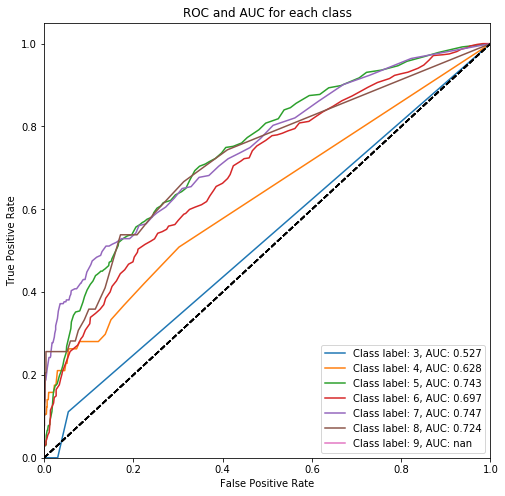

In [28]:
plot_roc_curves(pca_fpr, pca_tpr, pca_roc_auc,n_classes)

AUC scores for each of the classes.

In [29]:
print("AUC values for RF classifier trained with features selected by PCA")
for key,value in pca_roc_auc.items():
    print("Class label:", classes[key], "\tAUC:", np.round(value,3))

AUC values for RF classifier trained with features selected by PCA
Class label: 3 	AUC: 0.527
Class label: 4 	AUC: 0.628
Class label: 5 	AUC: 0.743
Class label: 6 	AUC: 0.697
Class label: 7 	AUC: 0.747
Class label: 8 	AUC: 0.724
Class label: 9 	AUC: nan


#### MIFS

In [30]:
mifs_rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
mifs_rf.fit(X_train[:,mifs_best_subset], y_train) 
mifs_rf_ypred_prob = mifs_rf.predict_proba(X_test[:,mifs_best_subset])
mifs_rf_ypred = np.array( [classes[np.argmax(x)] for x in mifs_rf_ypred_prob] )

In [31]:
mifs_acc_score = accuracy_score(y_test, mifs_rf_ypred)
print("MIFS trained RF accuracy score:", 100*round(mifs_acc_score,3), "%")

MIFS trained RF accuracy score: 63.800000000000004 %


In [32]:
mifs_precision_score = precision_score(y_test, mifs_rf_ypred, average="macro")
print("MIFS trained RF presicion score:", 100*np.round(mifs_precision_score,2), "%")

MIFS trained RF presicion score: 59.0 %


c:\python\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [33]:
mifs_recall_score = recall_score(y_test, mifs_rf_ypred, average="macro")
print("PCA trained RF recall score:", 100*np.round(mifs_recall_score,3), "%")

PCA trained RF recall score: 39.7 %


In [34]:
mifs_fpr, mifs_tpr, mifs_roc_auc = calc_fpr_tpr_auc(mifs_rf_ypred_prob,n_classes,classes,y_test)

c:\python\lib\site-packages\sklearn\metrics\ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


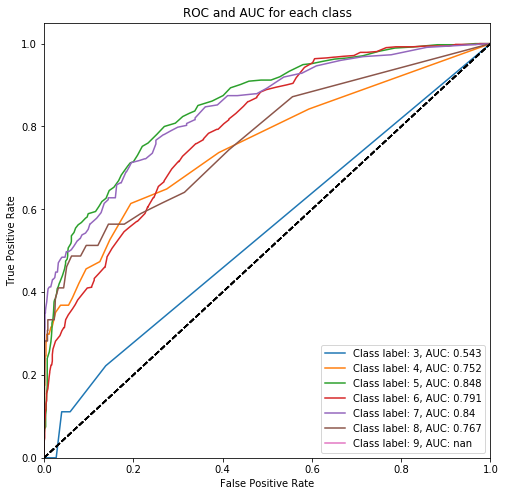

In [35]:
plot_roc_curves(mifs_fpr, mifs_tpr, mifs_roc_auc,n_classes)

In [36]:
print("AUC values for RF classifier trained with features selected by MIFS")
for key,value in mifs_roc_auc.items():
    print("Class label:", classes[key], "\tAUC:", np.round(value,3))

AUC values for RF classifier trained with features selected by MIFS
Class label: 3 	AUC: 0.543
Class label: 4 	AUC: 0.752
Class label: 5 	AUC: 0.848
Class label: 6 	AUC: 0.791
Class label: 7 	AUC: 0.84
Class label: 8 	AUC: 0.767
Class label: 9 	AUC: nan


####  BDS 

In [37]:
bds_rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
bds_rf.fit(X_train[:,bds_best_subset], y_train) 
bds_rf_ypred_prob = bds_rf.predict_proba(X_test[:,bds_best_subset])
bds_rf_ypred = np.array( [classes[np.argmax(x)] for x in bds_rf_ypred_prob] )

In [38]:
bds_acc_score = accuracy_score(y_test, bds_rf_ypred)
print("MIFS trained RF accuracy score:", 100*np.round(bds_acc_score,3), "%")

MIFS trained RF accuracy score: 65.2 %


In [39]:
bds_precision_score = precision_score(y_test, bds_rf_ypred, average="macro")
print("MIFS trained RF presicion score:", 100*np.round(bds_precision_score,2), "%")

MIFS trained RF presicion score: 56.99999999999999 %


c:\python\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [40]:
bds_recall_score = recall_score(y_test, bds_rf_ypred, average="macro")
print("PCA trained RF recall score:", 100*np.round(bds_recall_score,2), "%")

PCA trained RF recall score: 39.0 %


In [41]:
bds_fpr, bds_tpr, bds_roc_auc = calc_fpr_tpr_auc(bds_rf_ypred_prob,n_classes,classes,y_test)

c:\python\lib\site-packages\sklearn\metrics\ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


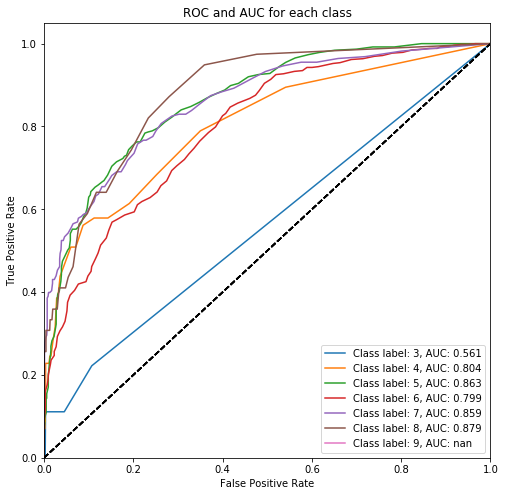

In [42]:
plot_roc_curves(bds_fpr, bds_tpr, bds_roc_auc,n_classes)

In [43]:
print("AUC values for RF classifier trained with features selected by BDS")
for key,value in bds_roc_auc.items():
    print("Class label:", classes[key], "\tAUC:", np.round(value,3))

AUC values for RF classifier trained with features selected by BDS
Class label: 3 	AUC: 0.561
Class label: 4 	AUC: 0.804
Class label: 5 	AUC: 0.863
Class label: 6 	AUC: 0.799
Class label: 7 	AUC: 0.859
Class label: 8 	AUC: 0.879
Class label: 9 	AUC: nan


###  Mean AUC for each method

In [44]:
def mean_AUC(roc_auc_scores):
    aucs = [auc for auc in roc_auc_scores.values() if not np.isnan(auc)]
    return np.mean(aucs)

In [45]:
mean_aucs = [mean_AUC(auc) for auc in [pca_roc_auc,mifs_roc_auc,bds_roc_auc]]

## Results Summary

Given the results of the AUC obtained via different feature subset selection methods, a summary table is presented.

In [46]:
summary = np.array(
    [[pca_acc_score, pca_precision_score, pca_recall_score, mean_aucs[0]],
    [mifs_acc_score, mifs_precision_score, mifs_recall_score, mean_aucs[1]],
    [bds_acc_score, bds_precision_score, bds_recall_score, mean_aucs[2]]]
)
summary = np.round(summary,3)

In [47]:
summary_table = pd.DataFrame(summary, columns=['accuracy', 'precision', 'recall', 'mean AUC'], 
                             index=["PCA", "MIFS", "BDS"])

Summary table of results obtained after training a random forest classifier via different feature subset selection methods.

In [48]:
summary_table

,accuracy,precision,recall,mean AUC
PCA,0.547,0.416,0.343,0.677
MIFS,0.638,0.587,0.397,0.757
BDS,0.652,0.568,0.390,0.794


It must be noticed that the differences of the results of the MIFS and BDS are not statistically significant and might be due to chance. Additionally the computations required to find the feature subset via de MIFS are significantly lower than those for the BDS method, since it is not necessary to fit a model for every function evaluation, which is the main difference between filter and wrapper methods.